# Within-DS segment class analysis
UMAP on DS segments to determine whether there is any within-class variation that can be described by the labelled predictors

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

In [2]:
import avgn

In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir, FIGURE_DIR

In [4]:
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set
from avgn.visualization.projections import scatter_spec

In [5]:
from scipy.stats import kruskal
from sklearn.metrics import silhouette_score, silhouette_samples

In [6]:
from avgn.utils.general import save_fig

In [7]:
DATASET_ID = "git_repos"

In [8]:
DT_ID = '2022-03-04_18-41-29'

In [9]:
seg_df = pd.read_pickle(DATA_DIR / DATASET_ID / DT_ID /  'segment_df_umap_combinedtidied.pickle')
seg_df[:3]

,start_time,end_time,labels,ID,start_times,end_times,call_label,call_start,seg_pos_call,call_unique_num,...,location,sex,wav_loc,key,rate,specs,umap,comb_labels,call_lab_simp,combi_lab_simp
0,0.753604,0.776773,DS,0,0.753604,0.776773,DSSHDS,0.753604,0,0,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[14.15081, 3.406464]",DS,DS-SH-DS,DS-SH-DS SH-LH
1,0.786865,0.835165,SH,1,0.786865,0.835165,DSSHDS,0.753604,1,0,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[5.388335, 10.057652]",SH,DS-SH-DS,DS-SH-DS SH-LH
2,0.855941,0.921160,DS,2,0.855941,0.921160,DSSHDS,0.753604,2,0,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[12.421062, 0.6991728]",DS,DS-SH-DS,DS-SH-DS SH-LH


In [10]:
len(seg_df)

1333

In [11]:
seg_df = seg_df.loc[(seg_df["comb_labels"]=="DS")]
seg_df[:3]

,start_time,end_time,labels,ID,start_times,end_times,call_label,call_start,seg_pos_call,call_unique_num,...,location,sex,wav_loc,key,rate,specs,umap,comb_labels,call_lab_simp,combi_lab_simp
0,0.753604,0.776773,DS,0,0.753604,0.776773,DSSHDS,0.753604,0,0,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[14.15081, 3.406464]",DS,DS-SH-DS,DS-SH-DS SH-LH
2,0.855941,0.921160,DS,2,0.855941,0.921160,DSSHDS,0.753604,2,0,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 290719 PM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[12.421062, 0.6991728]",DS,DS-SH-DS,DS-SH-DS SH-LH
0,1.218085,1.308841,DS,6,1.218085,1.308841,DS,1.218085,0,2,...,CRAWLEY,F,C:/Users/slwal/anaconda3/envs/PY36/avgn_paper-...,BWY MGGY Call Combo 1 300719 AM,44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[14.357888, 3.1225288]",DS,DS,DS SH-LH


In [12]:
len(seg_df)

468

In [13]:
seg_df.sort_values(by=['ID'], inplace=True)

BMYO 43


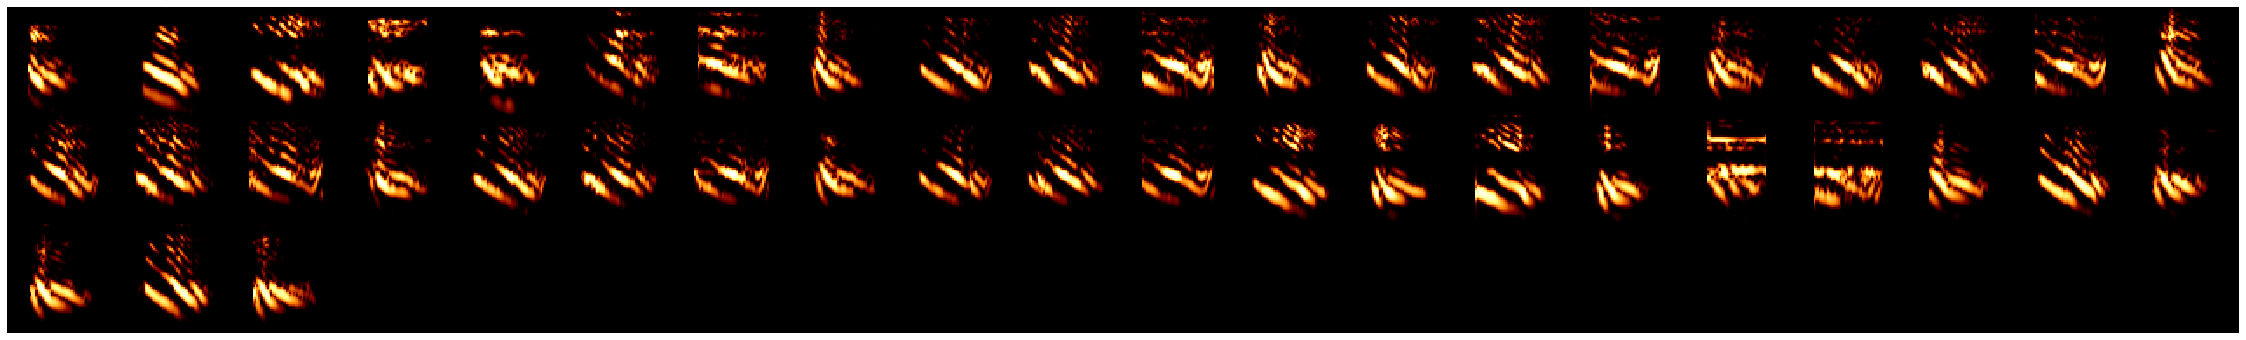

GBYM 18


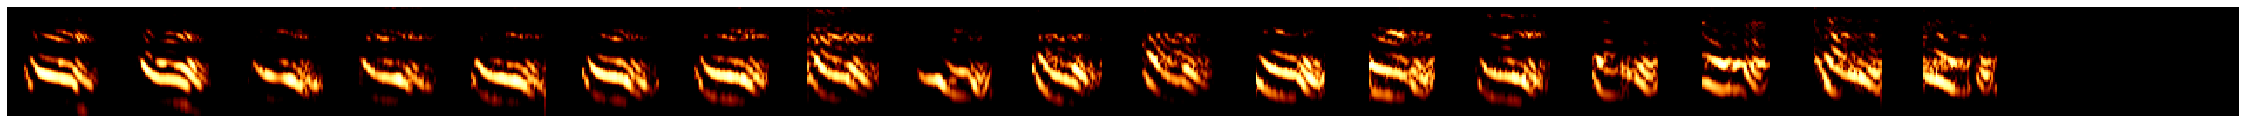

GON XF 19-21 9


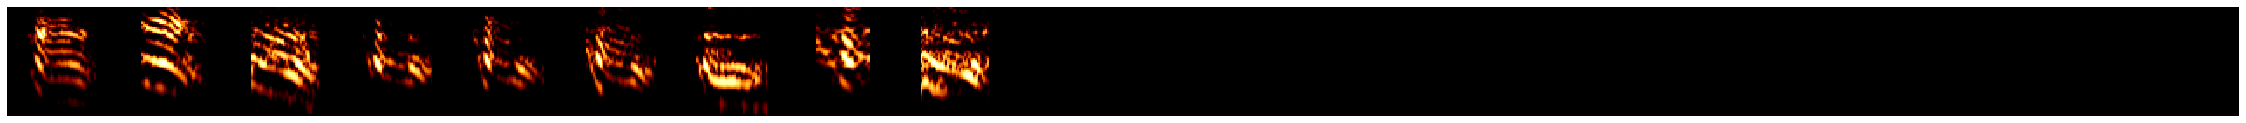

GON XM 20-21 5


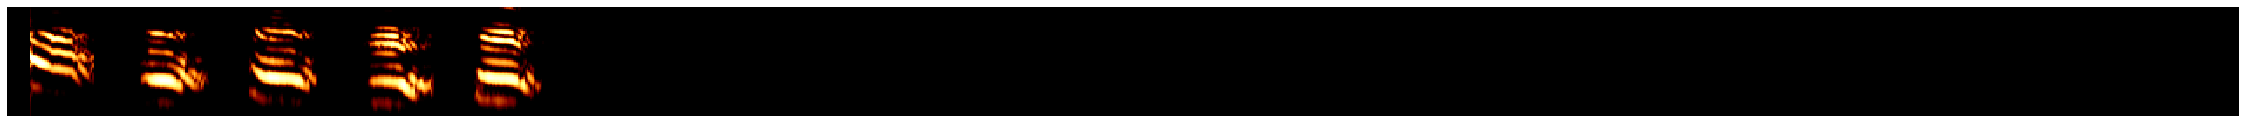

MGGY 31


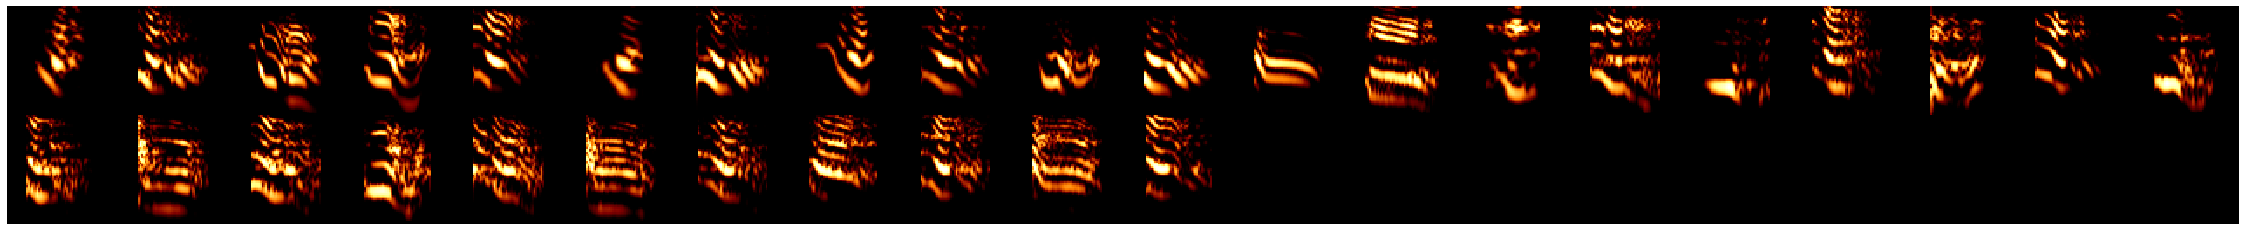

MOGO 36


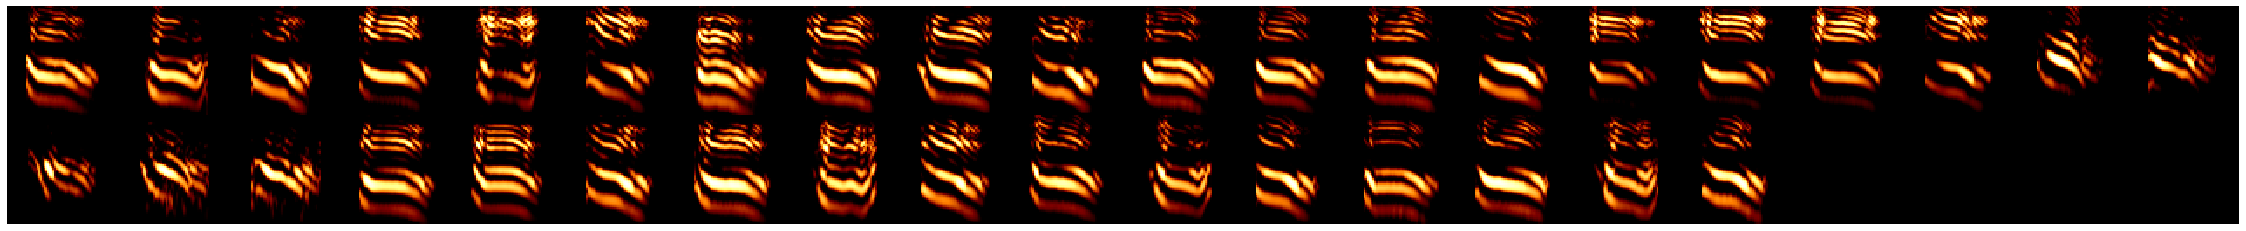

MOOO 13


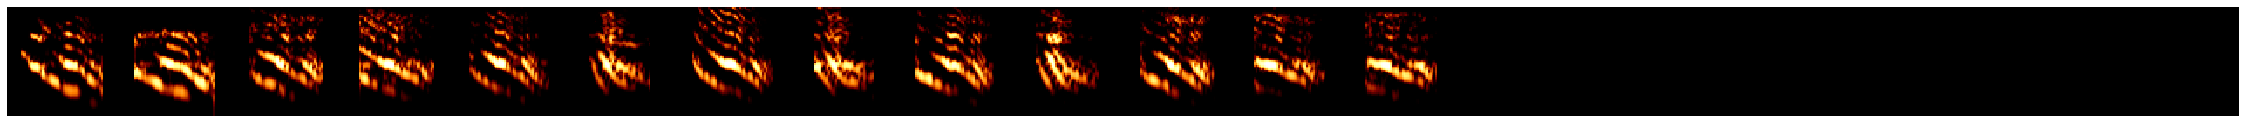

MORP 9


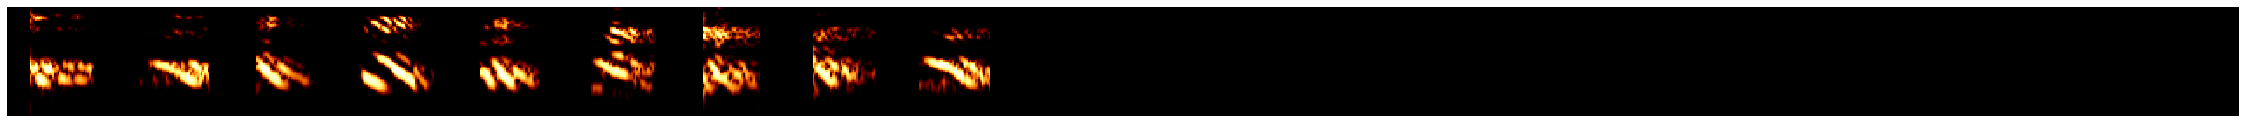

MOVY 10


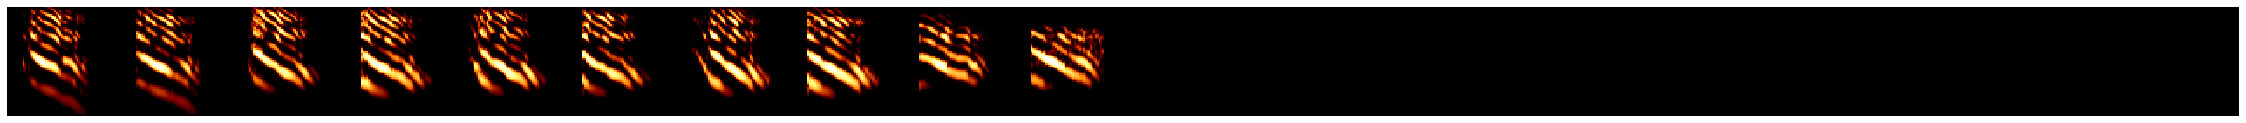

MRGO 41


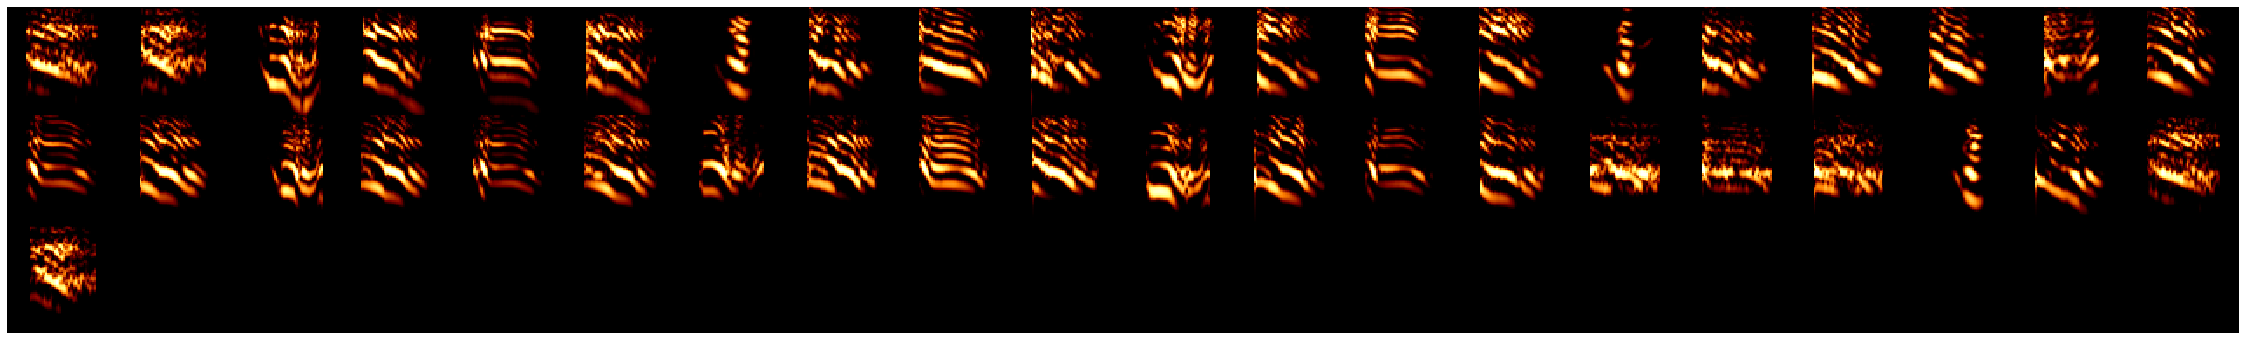

MXWW 22


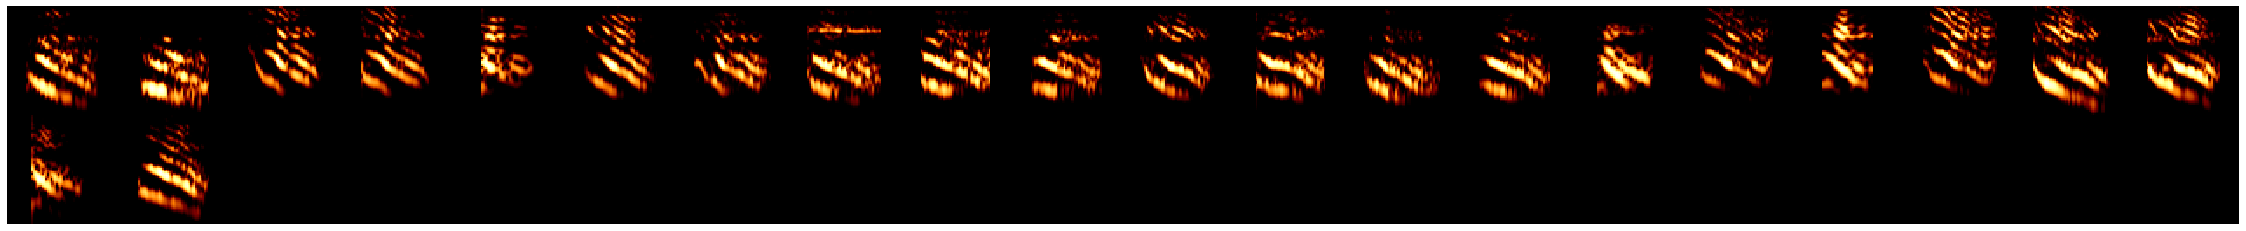

MXXBYX 1


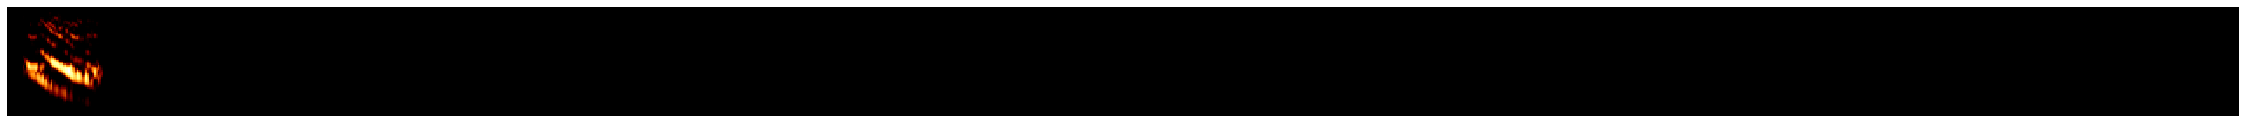

MXXGRY 36


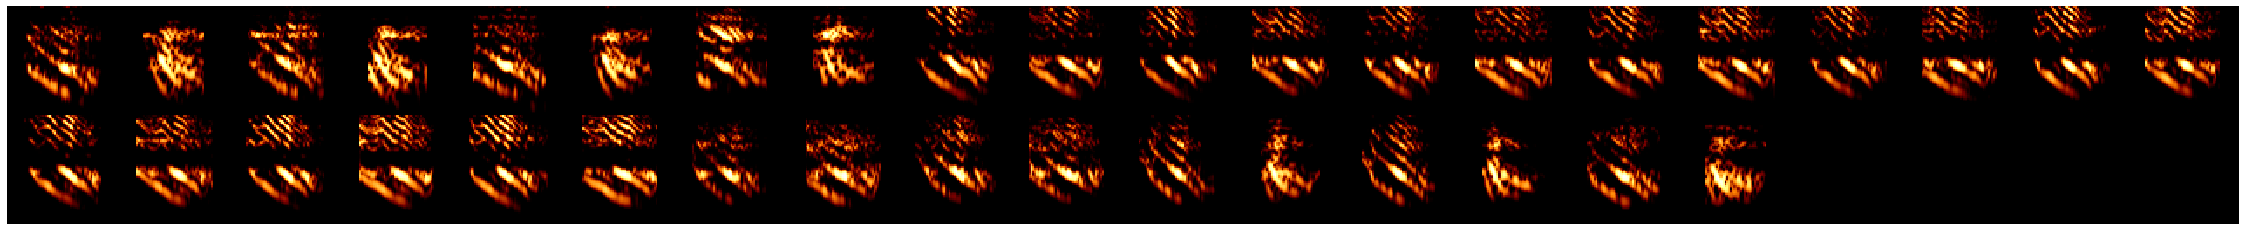

OMGO 38


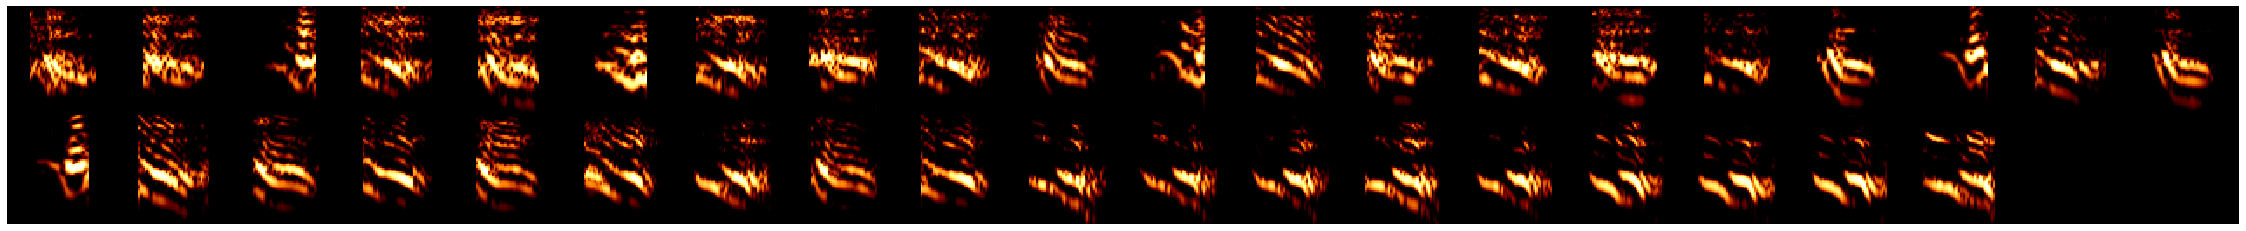

PMXRMX 6


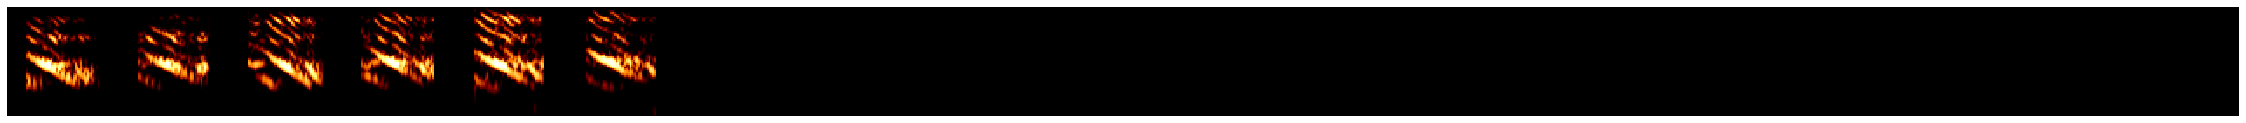

RMXGMX 30


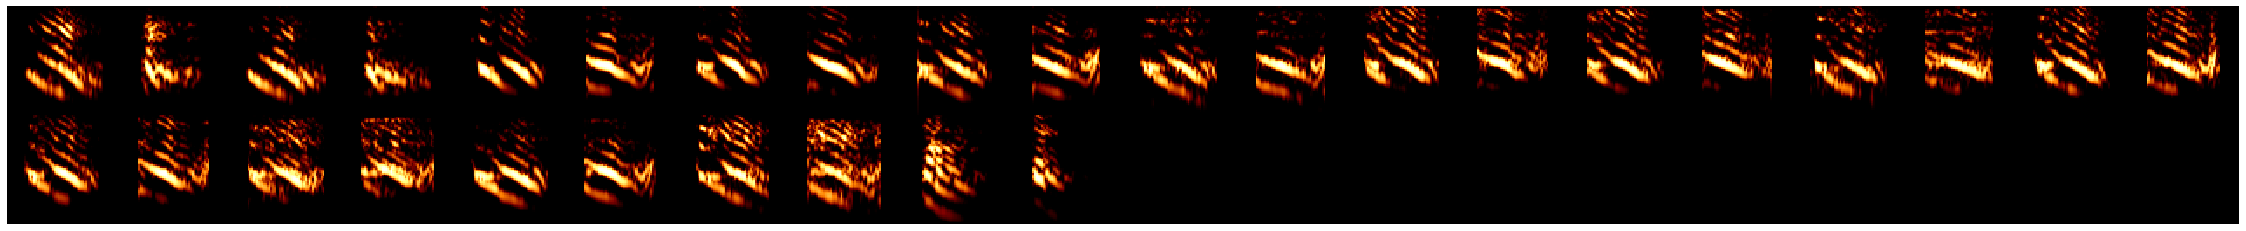

RMYG 16


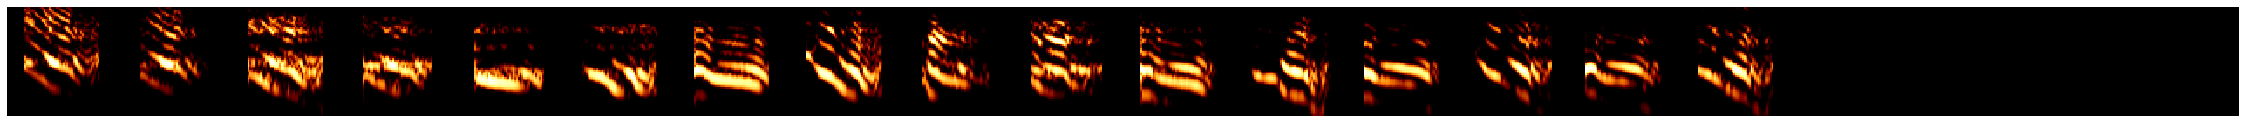

RYMR 7


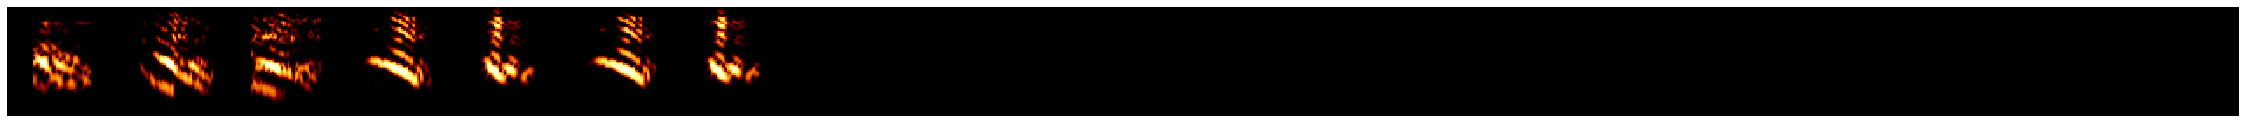

SCL XF 20-21 15


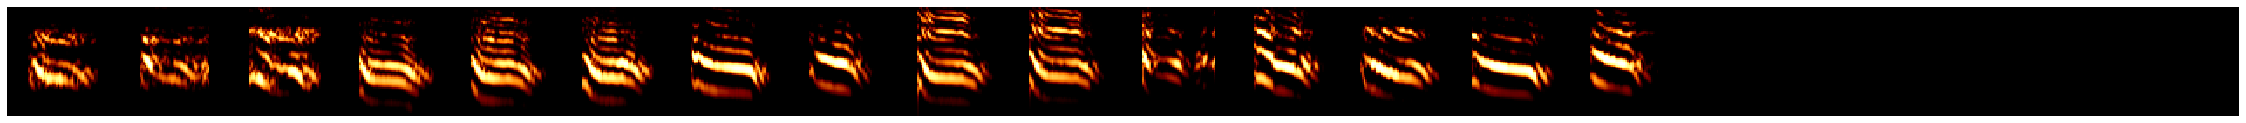

SCL XM 20-21 6


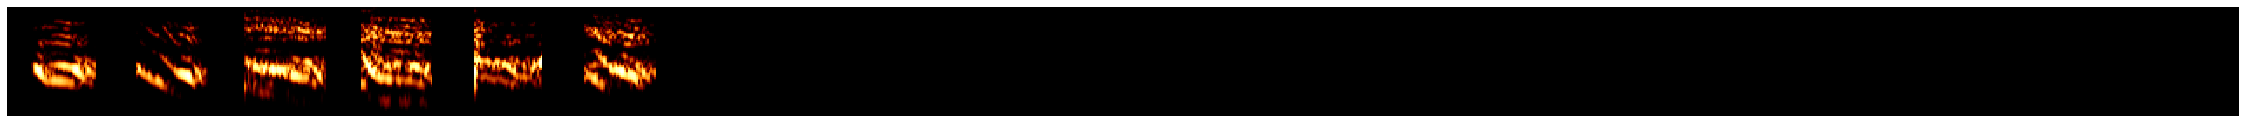

VVOM 16


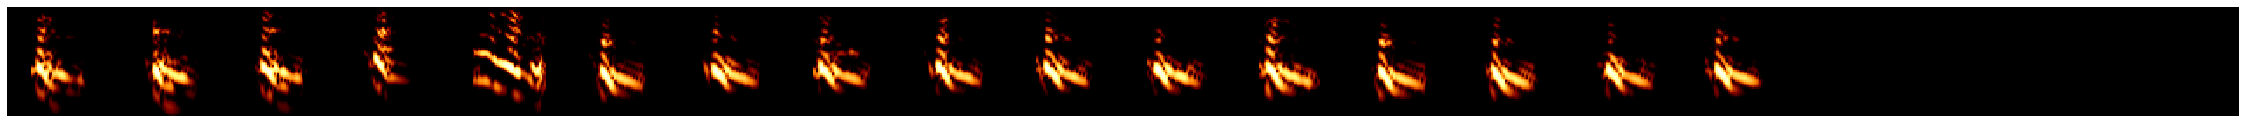

VVVM 50


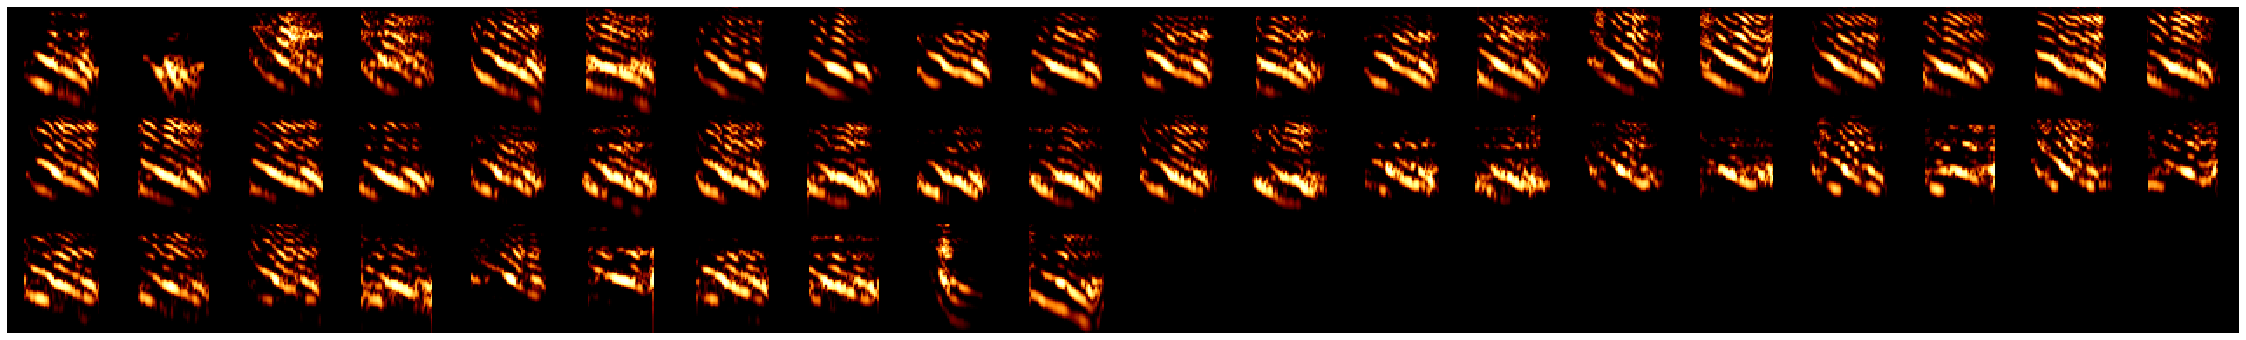

XF 20-21 10


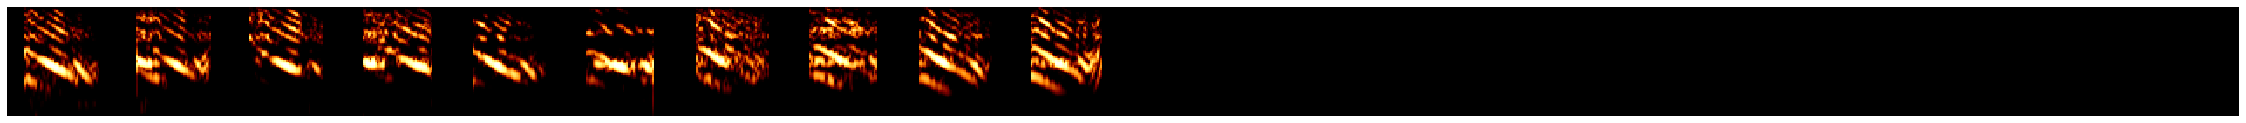

In [14]:
for indv in np.sort(seg_df.indv.unique()[:]):
    print(indv, np.sum(seg_df.indv == indv))
    specs = np.array([i/np.max(i) for i in seg_df[seg_df.indv == indv].specs.values])
    specs[specs<0] = 0
    
    draw_spec_set(specs, zoom=2,
                  maxrows=8, 
                  colsize=20)
    plt.show()

### Spectrograms for all individuals

In [15]:
def norm(x):
    return (x-np.min(x)) / (np.max(x) - np.min(x))

In [16]:
seg_df = seg_df[np.array([np.sum(i) > 0.0 for i in seg_df.specs.values])
]

In [17]:
specs = list(seg_df.specs.values)
specs = [norm(i) for i in tqdm(specs)]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

  0%|          | 0/468 [00:00<?, ?it/s]

(468, 4096)

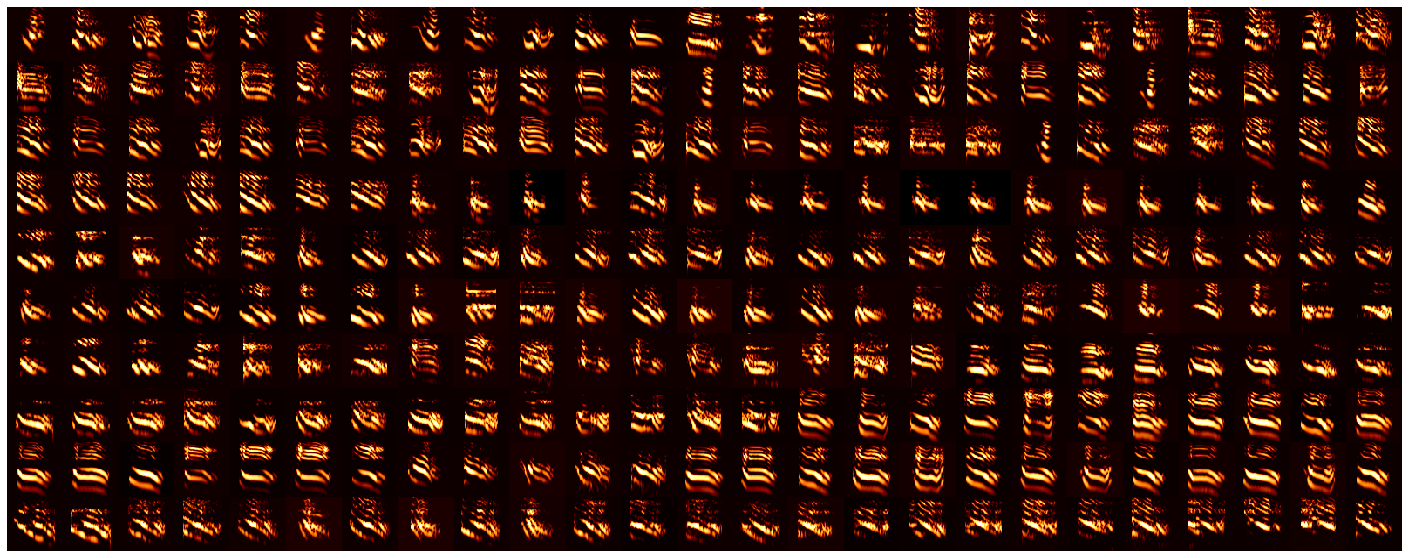

In [18]:
draw_spec_set(specs, zoom=1, maxrows=10, colsize=25)

In [19]:
fit = umap.UMAP(min_dist=0.0, verbose = True)
z = list(fit.fit_transform(specs_flattened))

UMAP(min_dist=0.0, verbose=True)
Construct fuzzy simplicial set
Sun Sep 11 18:33:05 2022 Finding Nearest Neighbors
Sun Sep 11 18:33:06 2022 Finished Nearest Neighbor Search
Sun Sep 11 18:33:08 2022 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Sun Sep 11 18:33:09 2022 Finished embedding


In [ ]:
nex = -1
scatter_spec(
    z,
    specs,
    column_size=12,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(20, 20),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': seg_df.indv.values,
        'alpha':1,
        's': 8,
        'show_legend': True,
        "color_palette": 'plasma',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,
    

);


In [ ]:
nex = -1
scatter_spec(
    z,
    specs,
    column_size=12,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(20, 20),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': seg_df.group.values,
        'alpha':1,
        's': 8,
        'show_legend': True,
        "color_palette": 'viridis',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,
    

);

In [ ]:
nex = -1
scatter_spec(
    z,
    specs,
    column_size=12,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(15, 15),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': seg_df.location.values,
        'alpha':1,
        's': 8,
        'show_legend': True,
        "color_palette": 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,
    

);

In [ ]:
nex = -1
scatter_spec(
    z,
    specs,
    column_size=12,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(15, 15),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': seg_df.seg_pos_call.values,
        'alpha':1,
        's': 10,
        'show_legend': True,
        "color_palette": 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,
    

);

In [ ]:
nex = -1
scatter_spec(
    z,
    specs,
    column_size=12,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(15, 15),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': seg_df.location.values,
        'alpha':1,
        's': 5,
        'show_legend': True,
        "color_palette": 'colorblind',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,
    

);

In [ ]:
nex = -1
scatter_spec(
    z,
    specs,
    column_size=12,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(15, 15),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': seg_df.sex.values,
        'alpha':1,
        's': 10,
        'show_legend': True,
        "color_palette": 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,
    

);

In [26]:
seg_df['umap'] = list(z)

## Calculate S and H for each predictor

In [27]:
indvscore = silhouette_score(list(np.array(list(seg_df['umap'].values))), labels = seg_df.indv.values)
groupscore = silhouette_score(list(np.array(list(seg_df['umap'].values))), labels = seg_df.group.values)
locscore = silhouette_score(list(np.array(list(seg_df['umap'].values))), labels = seg_df.location.values)
sexscore = silhouette_score(list(np.array(list(seg_df['umap'].values))), labels = seg_df.sex.values)
segposScore = silhouette_score(list(np.array(list(seg_df['umap'].values))), labels = seg_df.seg_pos_call.values)

In [28]:
segmentdata = {'Test': ['S'], 'Indv': [indvscore], 'Group':[groupscore], 'studysite':[locscore], 'Sex': [sexscore], 'Seg_pos': [segposScore]}
df = pd.DataFrame(segmentdata)

In [ ]:
df

In [52]:
#Individual H score
samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = seg_df.indv.values)
chance_samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = np.random.permutation(seg_df.indv.values))

In [ ]:
KWindv = kruskal(samples, chance_samples)
KWindv

In [67]:
#group H score
samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = seg_df.group.values)
chance_samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = np.random.permutation(seg_df.group.values))

In [ ]:
KWgroup = kruskal(samples, chance_samples)
KWgroup

In [77]:
#study site score
samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = seg_df.location.values)
chance_samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = np.random.permutation(seg_df.location.values))

In [ ]:
KWloc = kruskal(samples, chance_samples)
KWloc

In [87]:
#sex score
samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = seg_df.sex.values)
chance_samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = np.random.permutation(seg_df.sex.values))

In [ ]:
KWsex = kruskal(samples, chance_samples)
KWsex

In [97]:
#Seg pos in call score
samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = seg_df.seg_pos_call.values)
chance_samples = silhouette_samples(list(np.array(list(seg_df['umap'].values))), labels = np.random.permutation(seg_df.seg_pos_call.values))

In [ ]:
KWsegpos = kruskal(samples, chance_samples)
KWsegpos

In [ ]:
segmentdata = {'Test': ['S', 'H'], 'Indv': [indvscore, KWindv], 'Group':[groupscore, KWgroup], 'studysite':[locscore, KWloc], 'Sex': [sexscore, KWsex], 'Seg_pos': [segposScore, KWsegpos]}
df = pd.DataFrame(segmentdata)
df

In [102]:
#save df
save_loc = DATA_DIR / DATASET_ID / 'DS' /  'DS_segment.pickle'
ensure_dir(save_loc.as_posix())
seg_df.to_pickle(save_loc)